<a href="https://colab.research.google.com/github/asheshd/DES-Project-xG-PySpark-ML/blob/main/Expected_Goals_Analysis_with_PySpark_DES_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA 231o Data Engineering at Scale Project

## Expected Goal Analysis with PySpark

### Team Name : Fantastic Four


1.   Manideep G
2.   Manish S B
3.   Ashesh Deep


# Pre-requisites

### Import Libraries

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 199 kB 67.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=bef4ffa61dad6071191a24602b700811f1c81183d75823d9bc23d543c5b6a174
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import pyspark
pyspark.__version__

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, when, col, create_map, lit
from itertools import chain

### Mount the drive

In [3]:
# Mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load input Dataset with Goals

In [4]:
# Read the csv file for visualization. We do not use this data anywhere in our model

data = pd.read_csv('/content/drive/Shareddrives/DES_Project/events.csv')

In [5]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

941009
24446
21


In [6]:
data.columns

Index(['id_odsp', 'id_event', 'sort_order', 'time', 'text', 'event_type',
       'event_type2', 'side', 'event_team', 'opponent', 'player', 'player2',
       'player_in', 'player_out', 'shot_place', 'shot_outcome', 'is_goal',
       'location', 'bodypart', 'assist_method', 'situation', 'fast_break'],
      dtype='object')

In [7]:
# Create spark session

spark = SparkSession \
    .builder \
    .appName('xG Project Solution') \
    .getOrCreate()
  
spark

In [8]:
# Load the events and the info as spark sql dataframes

eventsDF = spark.read.option("header", True).option("inferSchema", True).option("nullable", 'NA').csv('/content/drive/Shareddrives/DES_Project/events.csv')
infoDF = spark.read.option("header", True).option("inferSchema", True).option("nullable", 'NA').csv('/content/drive/Shareddrives/DES_Project/ginf.csv')

In [9]:
# Print Schema

eventsDF.printSchema()

infoDF.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: string (nullable = true)
 |-- shot_outcome: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- bodypart: string (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: string (nullable = true)
 |-- fast_break: integer (nullable = true)

root
 |-- id_odsp: string (nullable = true)
 |-- link_odsp: string (nullable = true)
 |-- adv_stat

In [10]:
# Verify if the data loaded is correct and in the proper format

eventsDF.show(10)
type(eventsDF)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|             player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hamburg SV|Borussia Dortmund|      mladen petric|     gokhan tore|       NA|        NA|         6|       

pyspark.sql.dataframe.DataFrame

In [11]:
# Join id_odsp, country, date columns from infoDF on id_odsp

eventsDF = eventsDF.join(infoDF[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
eventsDF.printSchema()
eventsDF.show(10)
eventsDF.count()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: string (nullable = true)
 |-- shot_outcome: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- bodypart: string (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: string (nullable = true)
 |-- fast_break: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- date: timestamp (nullable = true)

+---------+---------

941009

In [12]:
# Extract year from the timestamp and append the column

extract_year = lambda x: x.strftime("%Y")
extract_year_udf = udf(extract_year)
eventsDF = eventsDF.withColumn("year", extract_year_udf("date"))
eventsDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|             player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hambur

In [13]:
eventsDF.filter(eventsDF.event_type==1).filter(eventsDF.player != '').count()

229134

In [14]:
# Create shotsDF dataframe by filtering event type == 1 and non-empty player

shotsDF = eventsDF.filter(eventsDF.event_type==1).filter(eventsDF.player != '').filter(eventsDF.player2 != '').filter(eventsDF.country != '')
shotsDF = shotsDF.withColumn("player", udf(lambda x: x.title())("player"))
shotsDF = shotsDF.withColumn("player2", udf(lambda x: x.title())("player2"))
shotsDF = shotsDF.withColumn("country", udf(lambda x: x.title())("country"))
shotsDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+
|UFot0hit/| UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|       Hambur

# Plots for each feature

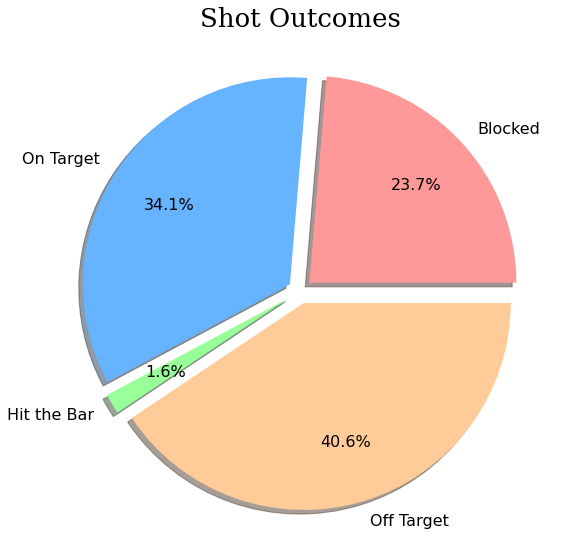

In [15]:
pieDF = shotsDF[['shot_outcome', 'id_event']].groupby('shot_outcome').count()
shotOutcomeDict = {1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'}
SO_mapping_expr = create_map([lit(x) for x in chain(*shotOutcomeDict.items())])

pieDF = pieDF.withColumn("shot_outcome", pieDF.shot_outcome.cast('integer')).na.drop()
pieDF = pieDF.withColumn('shot_outcome', SO_mapping_expr[pieDF['shot_outcome']])

fig, ax = plt.subplots(figsize=[8,8])
labels = pieDF.select('shot_outcome').rdd.flatMap(lambda x: x).collect()
x = pieDF.select('count').rdd.flatMap(lambda x: x).collect()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=x, autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
        textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

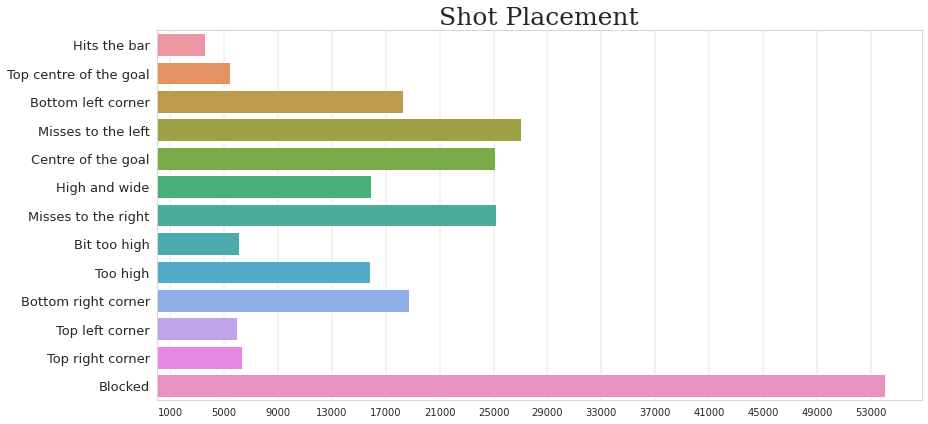

In [16]:
barDF = shotsDF[['shot_place', 'id_event']].groupby('shot_place').count()
shotPlaceDict = {1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                 5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                 9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                 12: 'Top left corner', 13: 'Top right corner'}
SP_mapping_expr = create_map([lit(x) for x in chain(*shotPlaceDict.items())])

barDF = barDF.withColumn("shot_place", barDF.shot_place.cast('integer')).na.drop()
barDF = barDF.withColumn('shot_place', SP_mapping_expr[barDF['shot_place']])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = barDF.select('shot_place').rdd.flatMap(lambda x: x).collect()
x = barDF.select('count').rdd.flatMap(lambda x: x).collect()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=x, y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

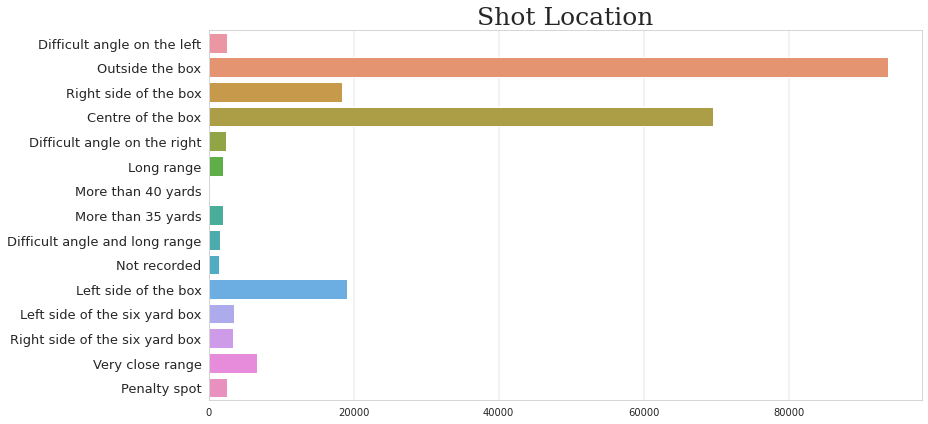

In [17]:
locDF = shotsDF[['location', 'id_event']].groupby('location').count()
locationDict = {
1:	'Attacking half',
2:	'Defensive half',
3:	'Centre of the box',
4:	'Left wing',
5:	'Right wing',
6:	'Difficult angle and long range',
7:	'Difficult angle on the left',
8:	'Difficult angle on the right',
9:	'Left side of the box',
10:	'Left side of the six yard box',
11:	'Right side of the box',
12:	'Right side of the six yard box',
13:	'Very close range',
14:	'Penalty spot',
15:	'Outside the box',
16:	'Long range',
17:	'More than 35 yards',
18:	'More than 40 yards',
19:	'Not recorded'
}
loc_mapping_expr = create_map([lit(x) for x in chain(*locationDict.items())])

locDF = locDF.withColumn("location", locDF.location.cast('integer')).na.drop()
locDF = locDF.withColumn('location', loc_mapping_expr[locDF['location']])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = locDF.select('location').rdd.flatMap(lambda x: x).collect()
x = locDF.select('count').rdd.flatMap(lambda x: x).collect()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=x, y=labels)
ax.set_yticklabels(labels, size = 13)
# ax.set_xticks(np.arange(1000,100000,10000))
ax.set_ylabel(ylabel='')
plt.title("Shot Location", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

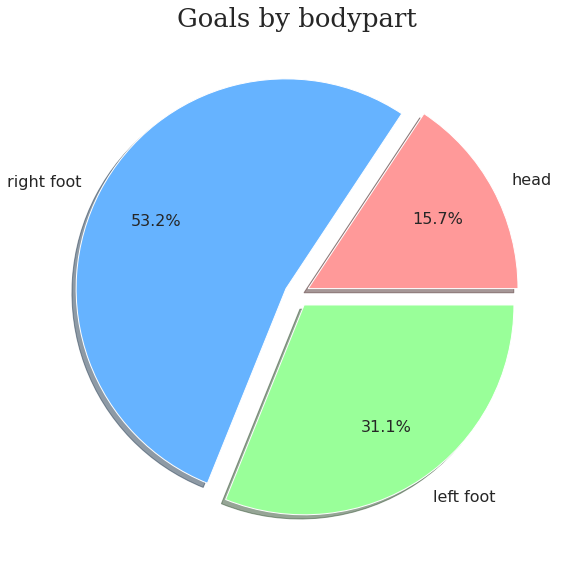

In [18]:
bpDF = shotsDF[['bodypart', 'id_event']].groupby('bodypart').count()
bodypartDict = {
1: 'right foot',
2: 'left foot',
3: 'head'
}
bp_mapping_expr = create_map([lit(x) for x in chain(*bodypartDict.items())])

bpDF = bpDF.withColumn("bodypart", bpDF.bodypart.cast('integer')).na.drop()
bpDF = bpDF.withColumn('bodypart', bp_mapping_expr[bpDF['bodypart']])

fig, ax = plt.subplots(figsize=[8,8])
labels = bpDF.select('bodypart').rdd.flatMap(lambda x: x).collect()
x = bpDF.select('count').rdd.flatMap(lambda x: x).collect()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=x, autopct="%.1f%%", labels=labels, explode=[0.06]*3, pctdistance=0.7, colors=colors, shadow=True, \
        textprops=dict(fontsize=16))
plt.title("Goals by bodypart", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

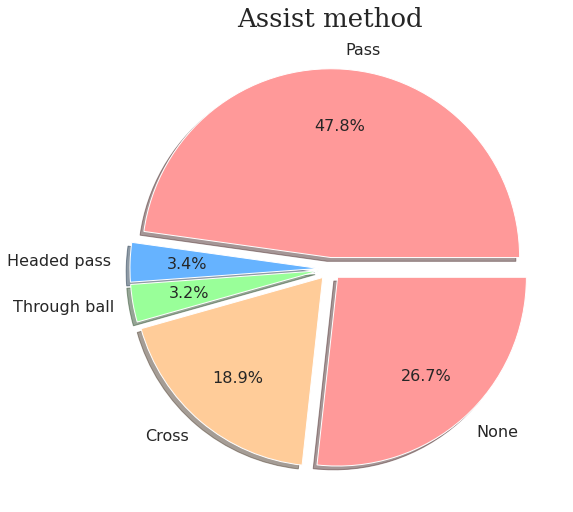

In [19]:
assistDF = shotsDF[['assist_method', 'id_event']].groupby('assist_method').count()
assistDict = {
0:	'None',
1:	'Pass',
2:	'Cross',
3:	'Headed pass',
4:	'Through ball'
}
assist_mapping_expr = create_map([lit(x) for x in chain(*assistDict.items())])

assistDF = assistDF.withColumn("assist_method", assistDF.assist_method.cast('integer')).na.drop()
assistDF = assistDF.withColumn('assist_method', assist_mapping_expr[assistDF['assist_method']])

fig, ax = plt.subplots(figsize=[8,8])
labels = assistDF.select('assist_method').rdd.flatMap(lambda x: x).collect()
x = assistDF.select('count').rdd.flatMap(lambda x: x).collect()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=x, autopct="%.1f%%", labels=labels, explode=[0.06]*5, pctdistance=0.7, colors=colors, shadow=True, \
        textprops=dict(fontsize=16))
plt.title("Assist method", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

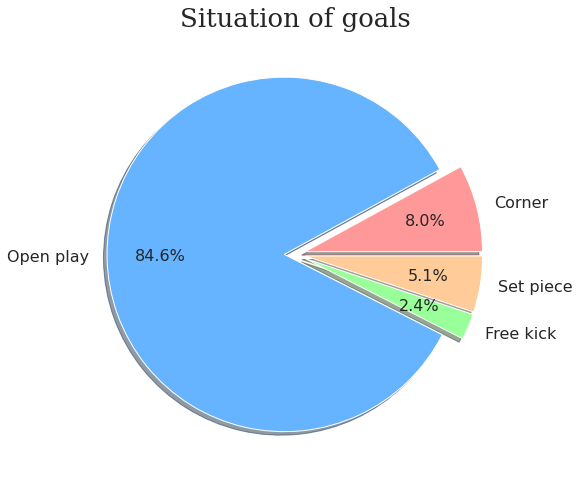

In [20]:
situationDF = shotsDF[['situation', 'id_event']].groupby('situation').count()
situationDict = {
1:	'Open play',
2:  'Set piece',
3:	'Corner',
4:	'Free kick'
}
situation_mapping_expr = create_map([lit(x) for x in chain(*situationDict.items())])

situationDF = situationDF.withColumn("situation", situationDF.situation.cast('integer')).na.drop()
situationDF = situationDF.withColumn('situation', situation_mapping_expr[situationDF['situation']])

fig, ax = plt.subplots(figsize=[8,8])
labels = situationDF.select('situation').rdd.flatMap(lambda x: x).collect()
x = situationDF.select('count').rdd.flatMap(lambda x: x).collect()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=x, autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
        textprops=dict(fontsize=16))
plt.title("Situation of goals", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

# Filter the required features for ML model

In [21]:
# Filter the columns which have all the relevant information about the shot and predict if it is a goal or not
# is_goal is the true label. We will not use this in the training

required_cols = ['shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation']

# Create dataDF dataframe with all the input columns
dataDF = shotsDF

# Create string indexer list
indexer = []

# Convert each column into integer type using string indexer without losing any features
for column in required_cols:
  temp = StringIndexer(inputCol=column, outputCol=column+"_index")
  indexer.append(temp)

# Pipeline
pipeline = Pipeline(stages=indexer)
dataDF = pipeline.fit(dataDF).transform(dataDF)

dataDF.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+----

# Expected Goals with PySpark Machine Learning

In [22]:
required_features = list(dataDF.columns[-6:]) # remove 'is_goal' because it is the label

assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(dataDF)

transformed_data.show(10)

+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+------------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|       event_team|         opponent|           player|           player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|
+---------+----------+----------+----+--------------------+----------+-----------+----+-----------------+-----------------+-----------------+-------------

In [23]:
# Split the data into training and testing data

(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

print("Total Data", transformed_data.count())
print("Total Training Data", training_data.count())
print("Total Test Data", test_data.count())

print("\nTraining Dataset")
training_data.show(5)

Total Data 229131
Total Training Data 183416
Total Test Data 45715

Training Dataset
+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+--------+------------------+----------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+
|  id_odsp|   id_event|sort_order|time|                text|event_type|event_type2|side|event_team|opponent|            player|         player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|
+---------+-----------+----------+----+--------------------+----------+-----------+----+----------+--

# Gradient-Boosted Trees (GBTs) Classifier

In [24]:
gbt = GBTClassifier(labelCol='is_goal', 
                            featuresCol='features',
                            maxDepth=5)

In [25]:
# Another classifier
# from pyspark.ml.classification import RandomForestClassifier
# rfc = RandomForestClassifier(labelCol='is_goal', 
#                             featuresCol='features',
#                             maxDepth=5)

In [26]:
# Fit the model on training data
model = gbt.fit(training_data)

# Predictions with Test Data

In [27]:
# Predictions with test data
predictions = model.transform(test_data)
predictions.show(5)

+---------+----------+----------+----+--------------------+----------+-----------+----+----------+--------+----------------+--------------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+-------+-------------------+----+----------------+------------------+--------------+--------------+-------------------+---------------+--------------------+--------------------+--------------------+----------+
|  id_odsp|  id_event|sort_order|time|                text|event_type|event_type2|side|event_team|opponent|          player|       player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|country|               date|year|shot_place_index|shot_outcome_index|location_index|bodypart_index|assist_method_index|situation_index|            features|       rawPrediction|         probability|prediction|
+---------+----------+----------+----+--------------------+----------+-----------+----+---

# Evaluate our model

In [28]:
# Evaluate our model
evaluator = MulticlassClassificationEvaluator(
    labelCol='is_goal', 
    predictionCol='prediction', 
    metricName='accuracy')

# Calculate Test Accuracy

In [29]:
accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.9396478180028437


In [30]:
from pyspark.ml.evaluation import RegressionEvaluator

regEvaluator = RegressionEvaluator(
    labelCol='is_goal', 
    predictionCol='prediction', 
    metricName='rmse')

rmse = regEvaluator.evaluate(predictions)
print('RMSE = ', rmse)

RMSE =  0.24566681093944354


# Player Analysis

In [31]:
def get_predictions(model, dataset):
  pred = model.transform(dataset)
  players = pred.select('player', 'is_goal', 'prediction')
  # Count the number of actual goals and expected goals per player

  metrics = players.groupBy('player').sum()
  metrics = metrics.withColumnRenamed('sum(is_goal)', 'true_goals').withColumnRenamed('sum(prediction)', 'expected_goals')

  # Calculate the difference between the expected goals and the true goals
  # Absolute difference indicates the number of goals made on top of the expected goals
  metrics = metrics.withColumn('difference', metrics.expected_goals - metrics.true_goals)

  # Sort by the least difference (Expected - True)
  result = metrics.sort('difference')
  result = result.withColumn('ratio', result['true_goals'] / result['expected_goals'])

  cor = result.stat.corr('true_goals', 'expected_goals')
  print("Correlation between Expected Goals and True Goals is", cor)

  return result

In [32]:
def do_player_analysis(model, dataset, player_names=None):
  
  result = get_predictions(model, dataset).limit(10)
  graphDF = result.toPandas()[['player', 'difference', 'true_goals', 'expected_goals', 'ratio']]

  fig, ax = plt.subplots(figsize=[12,5])
  ax = sns.barplot(x=abs(graphDF['difference']), y=graphDF['player'])
  ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
  ax.set_ylabel(ylabel='')
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
  plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
  ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
  plt.show()

  graphDF = graphDF.sort_values(['ratio', 'true_goals'], ascending=False).reset_index(drop=True)
  graphDF = graphDF.sort_values(['ratio', 'true_goals'], ascending=False).reset_index(drop=True)
  graphDF = graphDF[['player', 'ratio', 'true_goals', 'expected_goals', 'difference']].head(10)

  fig, ax = plt.subplots(figsize=[12,5])
  ax = sns.barplot(x=graphDF['ratio'], y=graphDF['player'])
  ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
  ax.set_ylabel(ylabel='')
  ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
  plt.title("Best Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
  ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
  plt.show()

Correlation between Expected Goals and True Goals is 0.9832245297428158


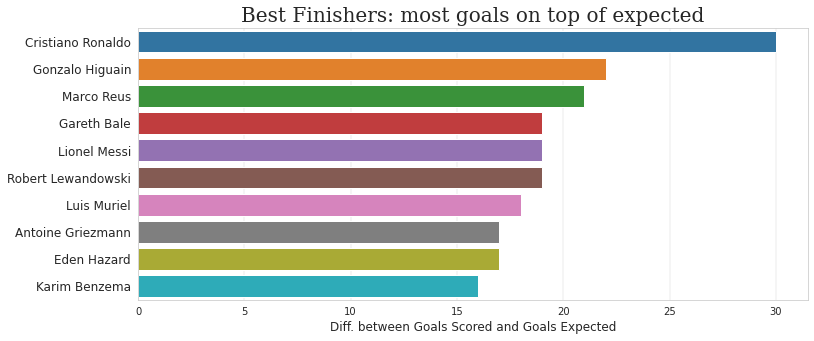

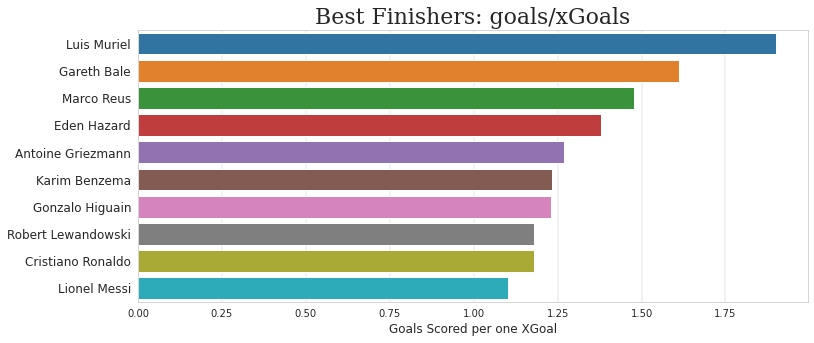

In [33]:
do_player_analysis(model, transformed_data)

In [34]:
test_data_len = test_data.count()
live_data_20 = training_data.union(test_data.limit(int(test_data_len*0.2)))
live_data_40 = training_data.union(test_data.limit(int(test_data_len*0.4)))
live_data_60 = training_data.union(test_data.limit(int(test_data_len*0.6)))
live_data_80 = training_data.union(test_data.limit(int(test_data_len*0.8)))
live_data_100 = training_data.union(test_data.limit(int(test_data_len*1.0)))

Correlation between Expected Goals and True Goals is 0.981437617556149


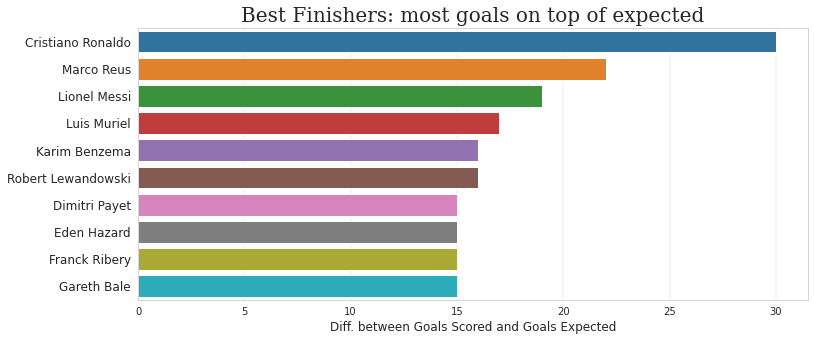

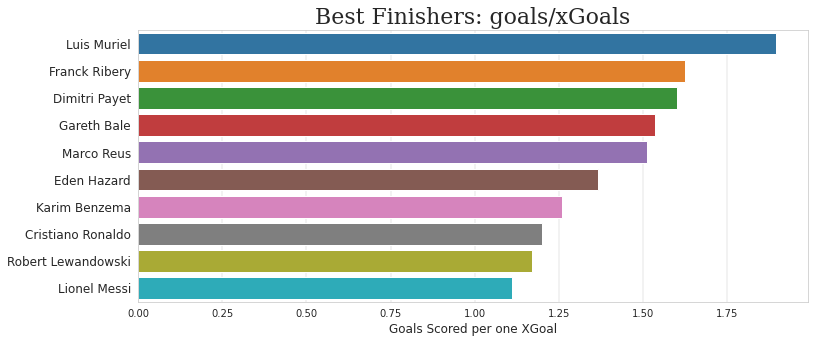

In [35]:
do_player_analysis(model, live_data_60)

Correlation between Expected Goals and True Goals is 0.983224529742814


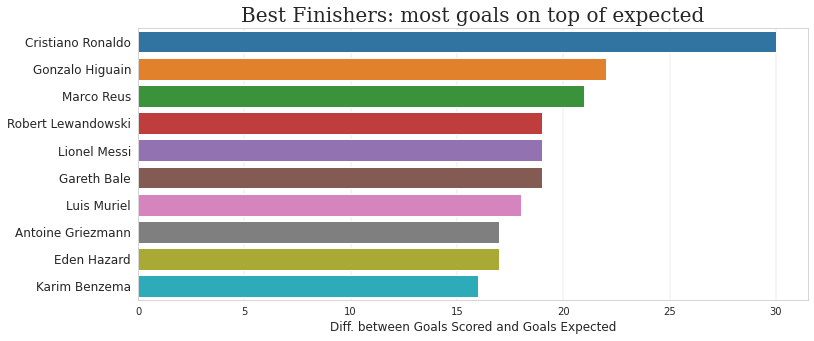

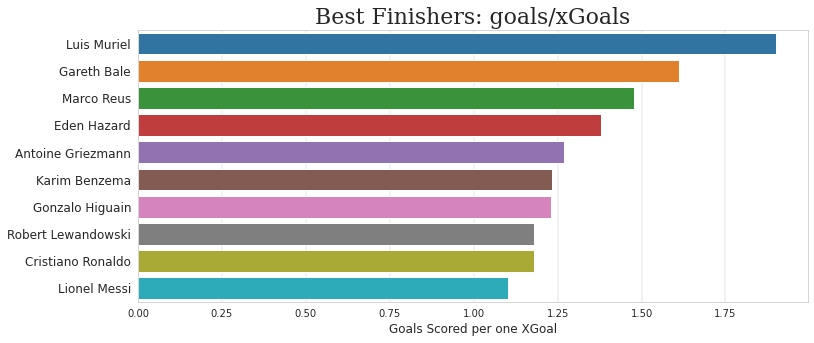

In [36]:
do_player_analysis(model, live_data_100)

# Scoring Ability of Players

In [37]:
res = model.transform(transformed_data)

# Top Header Players

In [38]:
playersH = res.select('player', 'is_goal', 'prediction', 'event_type', 'bodypart')
playersH = playersH.filter((playersH.event_type==1) & (playersH.bodypart==3))

headers_players = playersH.groupBy('player').sum()
headers_players = headers_players.withColumnRenamed('sum(is_goal)', 'true_goals').withColumnRenamed('sum(prediction)', 'expected_goals').withColumnRenamed('sum(event_type)', 'headers')
headers_players = headers_players.withColumn('difference', headers_players.expected_goals - headers_players.true_goals)
headers_players = headers_players.withColumn('header_ratio', headers_players['true_goals'] / headers_players['expected_goals'])
show_headers = headers_players.sort('difference', 'true_goals')

show_headers.show(10)

+------------------+----------+--------------+-------+----------+------------------+
|            player|true_goals|expected_goals|headers|difference|      header_ratio|
+------------------+----------+--------------+-------+----------+------------------+
| Cristiano Ronaldo|        36|          20.0|    159|     -16.0|               1.8|
|   Mario Mandzukic|        28|          13.0|    124|     -15.0|2.1538461538461537|
|        Andre Ayew|        17|           5.0|    111|     -12.0|               3.4|
|Klaasjan Huntelaar|        14|           3.0|     88|     -11.0| 4.666666666666667|
|  Imanol Agirretxe|        14|           3.0|    100|     -11.0| 4.666666666666667|
| Fernando Llorente|        25|          14.0|    141|     -11.0|1.7857142857142858|
| Christian Benteke|        13|           3.0|     95|     -10.0| 4.333333333333333|
|    Olivier Giroud|        20|          10.0|    140|     -10.0|               2.0|
| Antoine Griezmann|        14|           5.0|     78|      -9.0|

# Top Left Foot Players

In [39]:
playersL = res.select('player', 'is_goal', 'prediction', 'event_type', 'bodypart')
playersL = playersL.filter((playersL.event_type==1) & (playersL.bodypart==2))

left_foot_players = playersL.groupBy('player').sum()
left_foot_players = left_foot_players.withColumnRenamed('sum(is_goal)', 'true_goals').withColumnRenamed('sum(prediction)', 'expected_goals').withColumnRenamed('sum(event_type)', 'left_footers')
left_foot_players = left_foot_players.withColumn('difference', left_foot_players.expected_goals - left_foot_players.true_goals)
left_foot_players = left_foot_players.withColumn('left_foot_ratio', left_foot_players['true_goals'] / left_foot_players['expected_goals'])
show_left_footers = left_foot_players.sort('difference', 'true_goals')

show_left_footers.show(10)

+-----------------+----------+--------------+------------+----------+------------------+
|           player|true_goals|expected_goals|left_footers|difference|   left_foot_ratio|
+-----------------+----------+--------------+------------+----------+------------------+
|     Lionel Messi|       167|         153.0|         752|     -14.0| 1.091503267973856|
|  Florian Thauvin|        25|          13.0|         219|     -12.0|1.9230769230769231|
|       Marco Reus|        17|           7.0|          97|     -10.0|2.4285714285714284|
|Cristiano Ronaldo|        32|          22.0|         237|     -10.0|1.4545454545454546|
|  James Rodriguez|        23|          14.0|         162|      -9.0|1.6428571428571428|
|      Diego Costa|        25|          16.0|         111|      -9.0|            1.5625|
|   Angel Di Maria|        28|          19.0|         323|      -9.0|1.4736842105263157|
|     Arjen Robben|        42|          33.0|         296|      -9.0|1.2727272727272727|
|Antoine Griezmann|  

# Top Right Foot Players

In [40]:
playersR = res.select('player', 'is_goal', 'prediction', 'event_type', 'bodypart')
playersR = playersR.filter((playersR.event_type==1) & (playersR.bodypart==1))

right_foot_players = playersR.groupBy('player').sum()
right_foot_players = right_foot_players.withColumnRenamed('sum(is_goal)', 'true_goals').withColumnRenamed('sum(prediction)', 'expected_goals').withColumnRenamed('sum(event_type)', 'right_footers')
right_foot_players = right_foot_players.withColumn('difference', right_foot_players.expected_goals - right_foot_players.true_goals)
right_foot_players = right_foot_players.withColumn('right_foot_ratio', right_foot_players['true_goals'] / right_foot_players['expected_goals'])
show_right_footers = right_foot_players.sort('difference', 'true_goals')
show_right_footers.show(10)

+------------------+----------+--------------+-------------+----------+------------------+
|            player|true_goals|expected_goals|right_footers|difference|  right_foot_ratio|
+------------------+----------+--------------+-------------+----------+------------------+
|     Sergio Aguero|        51|          34.0|          271|     -17.0|               1.5|
|   Gonzalo Higuain|        86|          74.0|          362|     -12.0| 1.162162162162162|
|    Valere Germain|        19|           8.0|           93|     -11.0|             2.375|
|   Karim Bellarabi|        21|          10.0|          212|     -11.0|               2.1|
|       Luis Muriel|        27|          16.0|          217|     -11.0|            1.6875|
|      Carlos Tevez|        33|          22.0|          181|     -11.0|               1.5|
|   Bafetimbi Gomis|        48|          37.0|          268|     -11.0|1.2972972972972974|
|       Luis Suarez|        69|          58.0|          289|     -11.0|1.1896551724137931|

# Player Comparison

Comparison based on shots:- headers, left foot, right foot
## 'Lionel Messi', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Robert Lewandowski'

In [41]:
compare_players = ['Lionel Messi', 'Cristiano Ronaldo', 'Antoine Griezmann', 'Robert Lewandowski']

In [42]:
all_stats = headers_players.join(left_foot_players, ["player"]).join(show_right_footers, ["player"]).select("player", "header_ratio", "left_foot_ratio", "right_foot_ratio")
statsDF = all_stats.filter(all_stats.player.isin(compare_players))
statsDF.show()

+------------------+------------+------------------+------------------+
|            player|header_ratio|   left_foot_ratio|  right_foot_ratio|
+------------------+------------+------------------+------------------+
|Robert Lewandowski|         1.6|1.0909090909090908|1.1506849315068493|
| Antoine Griezmann|         2.8| 1.183673469387755|0.8888888888888888|
|      Lionel Messi|         4.0| 1.091503267973856| 0.967741935483871|
| Cristiano Ronaldo|         1.8|1.4545454545454546|1.0317460317460319|
+------------------+------------+------------------+------------------+



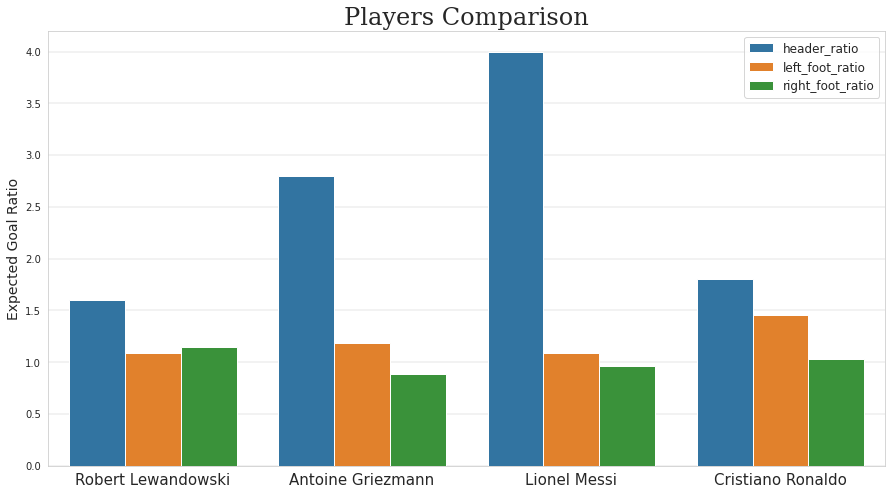

In [43]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[15,8])
sns.barplot(data=statsDF.toPandas().melt(id_vars='player', value_name='score', var_name='ratio'), x='player', y='score', hue='ratio')
ax.set_ylabel(ylabel='Expected Goal Ratio', fontsize=14)
ax.set_xlabel(xlabel='')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
plt.title("Players Comparison", fontsize=24, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
plt.show()